<center>
<h2>IPM-407: Modelación Computacional con Algoritmos Rápidos</h2>
<h3>Proyecto 1 - Multigrid</h3>
<h4>Daniel San Martín</h4>
</center>

# Tabla de Contenidos
* [1. Introducción](#introduccion)
    * [1.1 Algoritmos](#algoritmos)
* [2. Desarrollo](#desarrollo)
* [3. Conclusiones](#conclusiones)
* [4. Referencias](#referencias)

<div id="introduccion" />
## 1. Introducción

En el siguiente trabajo se analizará el algoritmo **Multigrid** para la solución de ecuaciones diferenciales. Para la impementación de los métodos se utilizará la *Ecuación de Poisson*, que es una ecuación diferencial parcial (EDP) de tipo elíptica ampliamente utilzada en problemas de ingeniería mecánica. Esta EDP es de la forma

\begin{equation}
    \Delta u = f 
\end{equation}

donde $\Delta$ es el operador *Laplaciano* el cual tambien se denota como $\nabla^2$.

### Algoritmos

A continuación se presenta una breve reseña de los algoritmos que serán utilizados en el trabajo. Para esto, es necesario tener presente la discretización de segundo orden de la EDP de Poisson:

\begin{equation}
\begin{split}
    \Delta u &= f \\
    \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} &= f \\
    \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta x^2} + \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{\Delta y^2} & = f_{i,j}
\end{split}
\end{equation}

Donde $i,j$ denota la evaluación del punto en el par $(i\Delta x, j\Delta y)$. Nótese que si $\Delta x = \Delta y = h$, podemos simplificar la ecuación a

\begin{equation}
    u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j} = h^2 f_{i,j}
\end{equation}

Vale decir que esto genera un sistema de ecuaciones lineales representable de la forma $A\textbf{u}=\textbf{f}$, donde $A$ se conoce como la matriz de Laplace, $\textbf{u}$ corresponde a la solución aproximada en los puntos respectivos y $\textbf{f}$ es el vector de la evaluación de cada punto de la función $f$.

#### Método Gauss-Seidel

El **método de Gauss-Seidel** es un método iterativo utilizado para resolver sistemas de ecuaciones lineales. El método se llama así en honor a los matemáticos alemanes Carl Friedrich Gauss y Philipp Ludwig von Seidel y es similar al método de Jacobi.

En el contexto del problema que deseamos resolver, sea $A$ una matriz, $\textbf{u}$ el vector de aproximación de la solución y $\textbf{f}$ el vector del lado derecho del sistema, el método descompone la matriz $A$ en 3 matrices; $D$ matriz diagonal, $L$ matriz diagonal inferior y $U$ matriz diagonal superior, de esta forma el algoritmo puede ser escrito como:

\begin{equation}
\begin{split}
    A \textbf{u} & = \textbf{f} \\
    (D - L - U)\textbf{u} & = \textbf{f} \\
    (D - L)\textbf{u} & = \textbf{f} + U\textbf{u} \\ 
    \textbf{u}^{k+1} & = (D - L)^{-1}\textbf{f} + U\textbf{u}^{k}
\end{split}
\end{equation}

Del algoritmo notamos que es necesario calcular una matriz inversa, lo que resulta muy costoso computacionalmente  ($O(n^3)$), es por esto que podemos aprovechar ciertas propiedades del orden de recorrido de la grilla que se desea simular además de la biblioteca *Numba* de *Python*, y de esta forma acelerar el cómputo de la simulación.

<img src="img/solvepath.png" width="30%" />
<center>*Figura 1. Orden de cálculo para cada nodo de la grilla.*</center>

Nótese que si expresamos el método G-S en términos de la discretización realizada anteriormente obtenemos la siguiente expresión 

\begin{equation}
    u^{k+1}_{i,j} = \frac{1}{4} \left(u^{k+1}_{i,j-1} + u^k_{i,j+1} + u^{k+1}_{i-1,j} + u^k_{i+1,j} - h^2 f_{i,j} \right)
\end{equation}

donde podemos tomar el orden mostrado en la *Figura 1* para que cada punto $u^{k}$ se actualice justo antes que $u^{k+1}$ los necesite en su cálculo y de esta manera no tener problemas de incoherencia en cuanto a las aproximaciones. Dado que es necesario recorrer un doble ciclo, la biblioteca de *Python* mencionada anteriormente nos ayudará a acelerar el cálculo (más aún cuando es necesaria una cantidad no menor de iteraciones para obtener una buena solución).

#### V-Cycle

Este algoritmo se desplaza hasta la malla más gruesa, que puede consistir en uno o unos pocos puntos de la malla interior, y luego regresa a la malla más fina. La figura 2  muestra el comportamiento de las mallas según el orden en que se utilizan. Debido al patrón en este diagrama, este algoritmo se llama *V-Cycle*. Este algoritmo es considerado un tipo de *Multigrid*.

<img src="img/v-cycle.png" />
<center>*Figura 2. Diagrama V-Cycle*</center>

El algoritmo definido recursivamente es el siguiente:

\begin{equation}
    \textbf{v}^{h} \leftarrow V^{h}(\textbf{v}^{h}, \textbf{f}^{h}).
\end{equation}
1. Relajar $\nu_1$ veces sobre $A^h\textbf{u}^h=\textbf{f}^h$ con estimación inicial $\textbf{v}^h$.
2. Si $\Omega^h$ es la malla mas gruesa, entonces ir al paso 4.

   Sino
\begin{equation}
\begin{split}
    \textbf{f}^{2h} & \leftarrow I^{2h}_{h}(\textbf{f}^h - A^h\textbf{v}^h) \\
    \textbf{v}^{2h} & \leftarrow \textbf{0} \\
    \textbf{v}^{2h} & \leftarrow V^{2h}(\textbf{v}^{2h}, \textbf{f}^{2h}).
\end{split}
\end{equation}

3. Corregir $\textbf{v}^h \leftarrow \textbf{v}^h + I^{h}_{2h}\textbf{v}^{2h}$.
4. Relajar $\nu_2$ veces sobre $A^h\textbf{u}^h=\textbf{f}^h$ con estimación inicial $\textbf{v}^h$

#### Multigrid

Hay muchas variaciones de algoritmos *multigrid*, pero las características comunes son que se considera 
una jerarquía de discretizaciones (mallas). Los pasos importantes son

* *Suavizado*: Reducir error de alta frecuencia, por ejemplo utilizando un par de iteraciones del método de Gauss-Seidel.
* *Restricción*: Muestreo del error residual a una malla más gruesa.
* *Interpolación* o *prolongación*: Interpolar una corrección calculada sobre una malla más gruesa en una malla más fina.

La figura 3 muestra el paso por las mallas del algoritmo con $\nu_0 = 1$. Cada *V-cycle* es precedido por otro *V-cycle* de una malla gruesa diseñada para entregar una mejor estimación inicial posible.

<img src="img/fmg.png" />
<center>*Figura 3. Diagrama Multigrid*</center>

El Algoritmo *FUll Multigrid V-Cycle* de forma recursiva se define así:

\begin{equation}
    \textbf{v}^{h} \leftarrow FMG^h(\textbf{f}^h).
\end{equation}

1. Si $\Omega^h$ es la malla más gruesa, definir $\textbf{v} \leftarrow \textbf{0}$ e ir al paso 3.
   Sino
\begin{equation}
\begin{split}
    \textbf{f}^{2h} & \leftarrow I^{2h}_{h}(\textbf{f}^h), \\
    \textbf{v}^{2h} & \leftarrow FMG^{2h}(\textbf{f}^{2h}).
\end{split}
\end{equation}
2. Corregir $\textbf{v}^h \leftarrow I^{h}_{2h}\textbf{v}^{2h}$.
3. $\textbf{v}^{h} \leftarrow V^{h}(\textbf{v}^{h}, \textbf{f}^{h}) ~ \nu_0$ veces.

<div id="desarrollo" />
## 2. Desarrollo

La ecuación diferencial 

\begin{equation}
\begin{split}
    \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} & = -2[(1-6x^2)y^2(1-y^2) + (1-6y^2)x^2(1-x^2)] \\
    u & = 0 ~ \text{en} ~ x = 0, x = 1, y = 0, y = 1 \\
    0 & < x, y < 1
\end{split}
\end{equation}

tiene como solución analítica

\begin{equation}
    u(x,y) = (x^2 - x^4)(y^4-y^2)
\end{equation}

Resuelva la ecuación diferencial numéricamente con una discretización de segundo orden, usando

1. Gauss-Seidel
2. V-cycle, con $\nu_1=2$ y $\nu_2 = 2$ iteraciones subiendo y bajando en las mallas.
3. Multigrid, con $\nu_0=1$ V-cycle por malla.

Considere lo siguiente:

* Malla fina con 129 nodos por dimensión $(\Delta x = \frac{L}{N-1})$.
* Interpolación lineal y *full weightening* como operadores entre mallas.
* Toleracia de $10^{-8}$ del residual.

Su nota dependerá de un informe (no más de 10 páginas) y presentación (de no más de 10 minutos) donde deben

* Indicar el número de iteraciones, V-cycles, multigrids necesarios para llegar a la solución en cada caso.
* Indicar el tiempo de solución en cada caso ¿Se cumple la predicción teórica que vimos en clase? (recuerden que cuatificamos la cantidad de operaciones por unidad de ciclos de Gauss-Seidel).
* Realizar simulaciones con malla fina de 65, 129 y 257 nodos por dimensión usando V-cycles y Multigrid, y graficar el tiempo de solución versus el tamaño de malla fina (gráfico log-log) ¿Se cumple la complejidad algoritmica que derivamos en clase?
* Estudie el efecto de variar $\nu_0$, $\nu_1$ y $\nu_2$ ¿Puede proponer una combinación ideal?
* Estudie el efecto de cambiar full weightening por injection

En su informe y presentación deben además incluir una breve reseña del algoritmo e implementación, y sus conclusiones.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import jit

In [2]:
def plot(x, y, u, plot_title, plot_type="3D"):
    """
    Grafica la solucion del problema.
    
    Parametros
    -----------
    x: numpy.array
       Arreglo para el eje X
    y: numpy.array
       Arreglo para el eje Y
    u: numpy.array
       Matriz de soluciones - u(x,y)
    plot_title: string
        Nombre del grafico
    plot_type: string
        3D o de contorno
    
    Retorna
    ----------
    None, Grafico de la solcuion
    
    """
    if plot_type == "3D":
        fig = plt.figure(figsize=(12,8))
        ax = fig.gca(projection='3d')
        X, Y = np.meshgrid(x,y)
        surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, 
                               cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$u(x,y)$')
        ax.set_title(plot_title, fontsize=20)
    else:    
        plt.imshow(u, origin="lower", cmap=cm.jet, extent=[0,1,0,1])
        plt.title(plot_title, fontsize=20)
        plt.colorbar()
        
    plt.show()
    
    return None

In [3]:
def plotTN(N, tgs, tvc, tmg):
    """
    Grafica de tiempo vs N
    
    Parametros
    -----------
    N: array/list
       Valores de N
    tgs: array/list
        Tiempo de Gauss-Seidel
    tvc: array/list
        Tiempo de V-Cycle
    tmg: array/list
        Tiempo de Multigrid
    
    Retorna
    -----------
    None, grafico T vs N
    
    """
    plt.figure(figsize=(12,8))
    plt.loglog(N, tgs, 'b-o', label="Gauss-Seidel")
    plt.loglog(N, tvc, 'r-*', label="V-Cycle")
    plt.loglog(N, tmg, 'g-D', label="Multigrid")
    plt.grid(True)
    plt.legend()
    plt.xlabel(r"$\log(N)$", fontsize=16)
    plt.ylabel(r"$\log(t)$", fontsize=16)
    plt.title("Gráfico Tiempo vs Tamano")
    plt.plot()
    
    return None

In [4]:
def plotINFW(N, evci, evcf, emgi, emgf):
    """
    Grafica de Error vs N para 'Injection' y 'Fullweighting'
    
    Parametros
    -----------
    N: array/list
       Valores de N
    evci: array/list
        Error V-Cycle con injection
    evcf: array/list
        Error V-Cycle con fullweighting
    emgi: array/list
        Error Multigrid con injection
    emgf: array/list
        Error Multigrid con fullweighting
    
    Retorna
    -----------
    None, grafico T vs N
    
    """
    plt.figure(figsize=(12,8))
    plt.plot(N, evci, 'b-o', label="V-Cycle con Injection")
    plt.plot(N, evcf, 'r-*', label="V-Cycle con Fullweighting")
    plt.plot(N, emgi, 'g-D', label="Multigrid con Injection")
    plt.plot(N, emgf, 'k-x', label="Multigrid con Fullweighting")
    plt.grid(True)
    plt.legend()
    plt.xlabel(r"$N$", fontsize=16)
    plt.ylabel(r"$Error$", fontsize=16)
    plt.title("Gráfico Error vs Tamano")
    plt.plot()
    
    return None

In [5]:
def ff(x, y):
    """
    RHS de la ecuacion
    
    Parametros
    -----------
    x: array
        Valores de x
    y: array
        Valores de y
        
    Retorna
    -----------
    F(X,Y): matrix
        Valores de la funcion evaluada en (x,y)
        
    """
    X, Y = np.meshgrid(x, y)
    return -2 *((1-6*X**2) * Y**2 * (1-Y**2) + (1-6*Y**2) * X**2 * (1-X**2))

In [6]:
def fa(x, y):
    """
    Solucion analitica la EDP
    
    Parametros
    -----------
    x: array
        Valores de x
    y: array
        Valores de y
        
    Retorna
    -----------
    F(X,Y): matrix
        Valores de la funcion analitica evaluada en (x,y)
        
    """
    X, Y = np.meshgrid(x, y)
    return (X**2 - X**4) * (Y**4 - Y**2)

In [7]:
# Residual
@jit(nopython=True)
def L2_residual(v, b):
    """
    Calculo del error residual norma_L2(r = b - Ax)
    
    Parametros
    -----------
    v: array
        Solucion aproximada
    b: array
        Lado derecho del sistema
        
    Retorna
    -----------
    Error residual L2: float
        
    """
    dx = 1/(len(b) - 1)
    res = b[1:-1,1:-1] - (1/dx**2)*(v[:-2,1:-1] + v[2:,1:-1] \
                                    + v[1:-1,:-2] + v[1:-1,2:] - 4*v[1:-1,1:-1])
    return np.sqrt(np.sum((res*res)))

In [8]:
@jit(nopython=True)
def gauss_seidel(u, f, n_iter, tol=1e-8, verb=False):
    """
    Gauss-Seidel para ecuacion de Poissson con discretizacion en 2D.
    
    Parametros
    -----------
    u: array
        Aproximacion inicial
    f: array
        Lado derecho del sistema (o f en contexto de la EDP)
    n_iter: int
        Maximo numero de iteraciones
    tol: float
        Tolerancia del residuo
    verb: boolean
        Muestra informacion del algoritmo
    
    Retorna
    -----------
    u: array
        Aproximacion de la solucion del sistema
        
    """
    res = 1 # Residual
    k = 0 # Iteraciones
    L = 1
    h = L/(len(u)-1) # L/(N-1)

    while res > tol and k < n_iter:
        res = .0
        
        # Recorrido de la grilla segun Figura 1 de la introduccion
        for j in range(1, len(u)-1): 
            for i in range(1, len(u)-1):
                u[j,i] = .25 * (u[j,i-1] + u[j,i+1] + u[j-1,i] + u[j+1,i] - f[j,i]*h**2)        
            
        res = L2_residual(u, f)
        
        k += 1        
    
    if verb: print("Numero de iteraciones G-S:", k)
    return u

In [9]:
def interpolation(a):
    """
    Interpolacion lineal
    
    Parametros
    -----------
    a: array
        Matriz a interpolar
        
    Retorna
    -----------
    p: array
        Matriz con interpolacion lineal
        
    """
    m, n = a.shape
    p = np.empty((2*m-1, 2*n-1), float)
    
    p[0::2,0::2] = a[0:,0:]
    p[1:-1:2,0::2] = 0.5*(a[0:-1,0:] + a[1:,0:])
    p[0::2,1:-1:2] = 0.5*(a[0: ,0:-1] + a[0:,1:])
    p[1:-1:2,1:-1:2] = 0.25*(a[0:-1,0:-1] + a[1:,0:-1] + a[0:-1,1:]+a[1:,1:])
    
    return p

In [10]:
def restriction(a, rtype="fw"):
    """
    Matriz de restriccion
    
    Parametros
    -----------
    a: array
        Matriz a restringir
    rtype: string
        Tipo de restriccion 
        "in": injection, "hw": halfweighting, fw: fullweighting (defecto)
        
    Retorna
    -----------
    r: array
        Matriz restringida
    
    """
    m, n = a.shape
    r = np.empty((int(m/2)+1, int(n/2)+1), float)
    
    if rtype == "fw": #Full weighting
        r[1:-1,1:-1] = 0.25 * a[2:-1:2,2:-1:2] + \
                    0.125 * (a[2:-1:2,1:-2:2] + a[2:-1:2,3: :2] \
                             + a[1:-2:2,2:-1:2] + a[3: :2,2:-1:2]) + \
                    0.0625 * (a[2:-1:2,:-3:2] + a[2:-1:2,2:-1:2] + \
                              a[4::2,:-3:2] + a[4::2,2:-1:2])
        r[0,0:] = a[0,0::2]
        r[-1,0:] = a[-1,0::2]
        r[0:,0] = a[0::2,0]
        r[0:,-1] = a[0: :2,-1]
        
    elif rtype == "in": # Injection
        r[1:-1,1:-1] = a[2:-1:2,2:-1:2]
        r[0,0:] = a[0,0::2]
        r[-1,0:] = a[-1,0::2]
        r[0:,0] = a[0::2,0]
        r[0:,-1] = a[0::2,-1]
        
    elif rtype == "hw": #Half weighting
        r[1:-1,1:-1] = 0.5*a[2:-1:2,2:-1:2] + 0.125 * (a[2:-1:2,1:-2:2] + \
                        a[2:-1:2,3: :2] + a[1:-2:2,2:-1:2] + a[3: :2,2:-1:2])
        r[0,0:] = a[0,0: :2]
        r[-1,0:] = a[-1,0: :2]
        r[0:,0] = a[0: :2,0]
        r[0:,-1] = a[0: :2,-1]
        
    return r

In [11]:
@jit(nopython=True)
def L2_error(v, u):
    """
    Calcula el error con norma L2
    
    Paramentros
    ------------
    v: array
        Aproximacion de la solucion
    u: array
        Solucion analitica
        
    
    Retorna
    L2_error: float
        Error con norma L2
    
    """
    return np.linalg.norm(v-u)/np.linalg.norm(u)

In [12]:
def Vcycle(v, f, nu1, nu2, rtype="fw", verb=False):
    """
    Algoritmo V-Cycle
    
    Parametros
    -----------
    v: array (matrix)
        Aproximacion inicial
    f: array (matrix)
        RHS de la EDP
    nu1: int 
        Cantidad de relajaciones iniciales
    nu2: int
        Cantidad de relajaciones finales
    rtype: string
        Tipo de restriccion 
        "in": injection, "hw": halfweighting, fw: fullweighting (defecto)
    verb: boolean
        Muestra informacion del algoritmo
    
    Retorna
    -----------
    u: array (matrix)
        Aproximacion luego de un V-Cycle
    
    """
    size = len(v) 
    dx = 1/(size-1)
    
    if verb: 
        print("V-Cycle: Bajando de malla (%d, %d)"%v.shape)
    
    # Paso 1 del algoritmo (Relajación inicial)
    v = gauss_seidel(v, f, nu1, verb=verb)
    
    # Paso 2 Si es la malla mas gruesa ir al paso 4.
    # Paso 2 Sino es la malla mas gruesa.
    if size > 7:
        
        # Calculo del residuo
        residual = f[1:-1,1:-1] - (1/dx**2)*(v[:-2,1:-1] + v[2:,1:-1] \
                                             + v[1:-1,:-2] + v[1:-1,2:] - 4*v[1:-1,1:-1])
        
        # Incluir condiciones de borde
        r = np.zeros_like(v) 
        r[1:-1,1:-1] = residual
        
        # Restriccion del residuo
        f2h = restriction(r, rtype=rtype)
        
        # Estimacion inicial v^{2h} = 0
        v2h = np.zeros_like(f2h)
        
        # V-Cycle en la siguiente malla mas gruesa
        vC = Vcycle(v2h, f2h, nu1, nu2, rtype=rtype, verb=verb) 
        
        # Paso 3. Corregir la estimación utilizando la interpolacion de la malla mas gruesa
        I = interpolation(vC)
        v = v + I         
        
        if verb:
            print("V-cycle: Subiendo a malla (%d, %d)"% I.shape)
        
    # Paso 4. Segunda relajacion 
    u = gauss_seidel(v, f, nu2, verb=verb)

    return u

def Nvcycles(v, f, nu1, nu2, rtype="fw", n_iter=30, tol=1e-8, verb=False):
    """
    Funcion que controla ejecuta N v-cycles hasta alcanzar tolerancia
    
    v: array (matri)
        Aproximacion inicial
    f: array (matrix)
        RHS de la EDP
    nu1: int 
        Cantidad de relajaciones iniciales
    nu2: int
        Cantidad de relajaciones finales
    rtype: string
        Tipo de restriccion 
        "in": injection, "hw": halfweighting, fw: fullweighting (defecto)
    n_iter: int
        Maximo numero de iteraaciones
    tol: float
        Tolerancia (defecto 1e-8)
    verb: boolean
        Muestra informacion del algoritmo
    
    Retorna
    -----------
    v: array (matrix)
        Aproximacion luego de N V-Cycle
    
    """
    k = 0
    res = 1
    
    while k < n_iter and res > tol:
        
        sol = Vcycle(v, f, nu1, nu2, rtype=rtype)
        v = sol
        
        res = L2_residual(v, f)
        
        k += 1
        
    if verb:
        print("N° de V-Cycles:", k)
        
    return v

In [13]:
def FMG(f, nu0, nu1, nu2, rtype="fw", verb=False):
    """
    Algoritmo Full Multigrid
    
    Parametros
    -----------
    f: array (matrix)
        RHS de la EDP
    nu0: int
        Numero de V-Cycles
    nu1: int 
        Cantidad de relajaciones iniciales para V-Cycle
    nu2: int
        Cantidad de relajaciones finales para V-Cycle
    rtype: string
        Tipo de restriccion 
        "in": injection, "hw": halfweighting, fw: fullweighting (defecto)
    verb: boolean
        Muestra informacion del algoritmo
    
    Retorna
    -----------
    u: array (matrix)
        Aproximacion luego de aplicar FMG
    
    """
    if verb: print("FMG: Bajando de malla (%d, %d)"% f.shape)
    
    # Paso 1. Si es la malla mas gruesa
    if len(f) < 7:
        v = np.zeros_like(f)
        return v
    
    # Paso 1 sino es la malla mas gruesa
    f2h = restriction(f, rtype=rtype)
    
    # FMG en la siguiente malla
    v2h = FMG(f2h, nu0, nu1, nu2, rtype=rtype, verb=verb)
    
    # Paso 2. Correccion de la aproximacion
    v = interpolation(v2h)
    
    if verb: print("FMG: Subiendo a malla (%d, %d)"% v.shape)
    
    # Paso 3. Aplicar V-Cycle nu0 veces
    for i in range(nu0):
        u = Vcycle(v, f, nu1, nu2, rtype=rtype, verb=verb)
    
    return u

In [18]:
def simulacion(N, method, plot_type=None, verb=False):
    """
    Realiza simulacion con parametros del proyecto
    
    Parametros
    -----------
    N: int
        Numero de puntos
    method: string
        Metodo numerico
    plot_type: string
        Tipo de grafico
    verb: boolean
        Muestra informacion de la simulacion
        
    Retorna
    ---------
    None, Muestra error y grafica la aproximacion la solucion
    
    """
    # Estimacion inicial
    v = np.zeros((N,N))
    
    # Malla XY
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    
    # Parametros solicitados
    nu0 = 1; nu1 = 2; nu2 = 2
    
    sol = None # Solucion
    
    # RHS de la EDP
    fff = ff(x,y)
    
    # Solucion numerica Gauss-Seidel
    if method == "gs":
        plot_title = "Solucion con Gauss-Seidel"
        print("Gauss-Seidel N=" + str(N))
        sol = gauss_seidel(v, fff, 100000, verb=verb)
    
    # Solucion numerica V-Cycle
    elif method == "vc":
        plot_title = "Solucion con V-Cycle"
        print("V-Cycle N=" + str(N))
        sol = Nvcycles(v, fff, nu1, nu2, rtype="fw", verb=verb)
        
    # Solucion numerica Multigrid
    elif method == "mg":
        plot_title = "Solucion con Multigrid"
        print("Multigrid N=" + str(N))
        sol = FMG(ff(x,y), nu0, nu1, nu2, verb=verb)
    
    # Solucion analitica
    else:
        plot_title = "Solucion Analitica"
        sol = fa(x, y)
        
    print("Error:", L2_error(sol, fa(x,y)))
    
    # Grafico de la solucion
    if plot_type != None:
        plot_title += " N = " + str(N)
        plot(x, y, sol, plot_title, plot_type)
    
    return None

### Resolución de la ecuación con distintos métodos

#### Solución Analítica

Error: 0.0


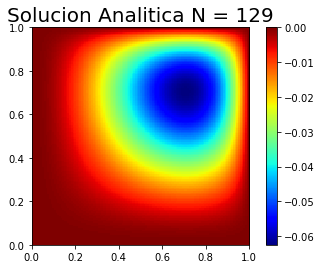

In [15]:
simulacion(129, 0, plot_type="3")

#### Solución con Gauss-Seidel

Gauss-Seidel N=129
Numero de iteraciones G-S: 37155
Error: 6.342442609087678e-05


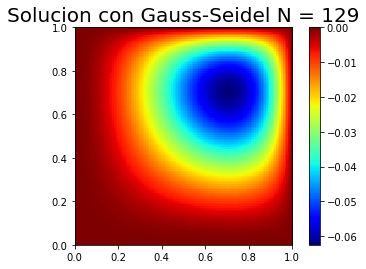

In [16]:
simulacion(129, "gs", plot_type="3", verb=True)

#### Solución con V-Cycle

V-Cycle N=129
N° de V-Cycles: 15
Error: 6.342429059058166e-05


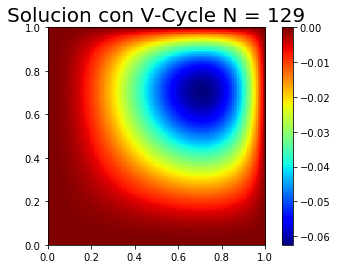

In [19]:
simulacion(129, "vc", plot_type="3", verb=True)

#### Solución con Multigrid

Multigrid N=129
Error: 0.0008790666235414615


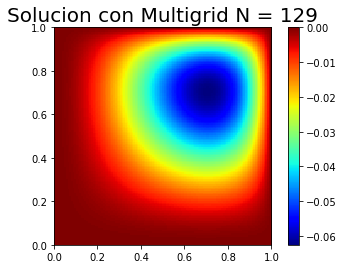

In [21]:
simulacion(129, "mg", plot_type="3", verb=False)

### Análisis de Complejidad

In [22]:
N = [65, 129, 257]

#### Gauss-Seidel

In [23]:
tgs = []
for n in N:
    temp = %timeit -r 1 -n 1 -o -q simulacion(n, "gs")
    tgs.append(temp.best)

Gauss-Seidel N=65
Error: 0.00025369922248488536
Gauss-Seidel N=129
Error: 6.342442609087678e-05
Gauss-Seidel N=257
Error: 1.608748914470042e-05


#### V-Cycle

In [24]:
tvc = []
for n in N:
    temp = %timeit -r 1 -n 1 -o -q simulacion(n, "vc")
    tvc.append(temp.best)

V-Cycle N=65
Error: 0.00025369887938721307
V-Cycle N=129
Error: 6.342429059058166e-05
V-Cycle N=257
Error: 1.58560501565188e-05


####  Multigrid

In [25]:
tmg = []
for n in N:
    temp = %timeit -r 1 -n 1 -o -q simulacion(n, "mg")
    tmg.append(temp.best)

Multigrid N=65
Error: 0.0015490869043630435
Multigrid N=129
Error: 0.0008790666235414615
Multigrid N=257
Error: 0.0004381958495731374


#### Gráfico Complejidad Algoritmica

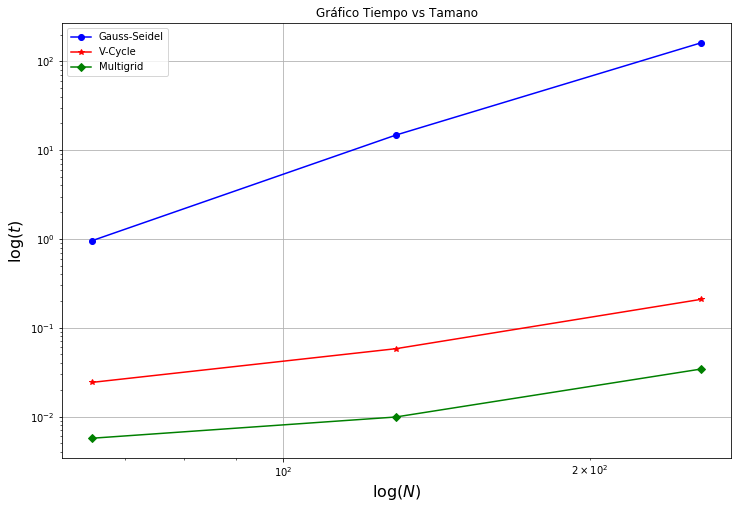

In [26]:
plotTN(N, tgs, tvc, tmg)

In [27]:
print("Tiempos G-S", tgs)
print("Tiempos V-C", tvc)
print("Tiempos MG", tmg)

Tiempos G-S [0.9560123540004497, 14.739999593999528, 161.1582996650004]
Tiempos V-C [0.024258906999421015, 0.05804482100029418, 0.20867340199947648]
Tiempos MG [0.005701106000742584, 0.0098825980003312, 0.034250179000082426]


Notamos que gráficamente se cumple la complejidad algoritmica derivada de la clase, en donde *Gauss-Seidel* tiene una complejidad $O(n^2)$ mientras que *V-Cycle* y *Multigrid* son de complejidad $O(n\log n)$.

#### Cálculo de Unidades de Operación

In [45]:
N = 65
x = np.linspace(0, 1, N)
y = x
v = np.zeros((N, N))
fff = ff(x,y)

In [51]:
%timeit -r 1 -n 1 gauss_seidel(v, fff, 1)

1 loop, best of 1: 108 µs per loop


In [52]:
%timeit -r 1 -n 1 Nvcycles(v, fff, 1, 1)

1 loop, best of 1: 18.8 ms per loop


In [53]:
%timeit -r 1 -n 1 FMG(fff, 1, 1, 1)

1 loop, best of 1: 4.3 ms per loop


Notamos que no se cumple exactamente el cálculo de operaciones por unidad de relajación, el cual para *V-Cycle* es de $\frac83 WU$ y para *FMG* es de $\frac72 WU$. Esta diferencia se le puede atribuir a los distintos resultados por la carga de la CPU o al uso de *Numba* en la aceleración del algoritmo G-S.

####  Pruebas con $\nu_0$, $\nu_1$ y $\nu_2$

In [43]:
N = 257
x = np.linspace(0, 1, N)
y = x

# Pruebas para variados nu_0, nu_1 y nu_2
min_error = 1
nu = np.zeros(3, dtype=int)
for nu0 in range(1, 6):
    for nu1 in range(1, 6):
        for nu2 in range(1, 6):
            sol = FMG(ff(x,y), nu0, nu1, nu2, rtype="fw", verb=False)
            fmg_error = L2_error(sol, fa(x,y))
            if fmg_error < min_error:
                min_error = fmg_error
                nu[0] = nu0; nu[1] = nu1; nu[2] = nu2
                              
print("Para nu0 = %d, nu1 = %d y nu2 = %d, el error es de: %f" %(nu[0], nu[1], nu[2], min_error))

Para nu0 = 1, nu1 = 5 y nu2 = 5, el error es de: 0.000218


De las pruebas realizadas anteriormente notamos que el menor valor de error lo tenemos con $\nu_0=1$, $\nu_1=5$ y $\nu_2=5$

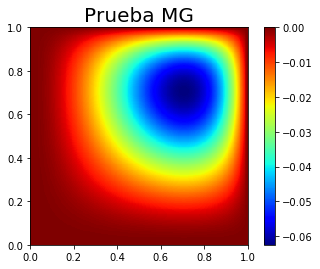

In [44]:
sol = FMG(ff(x,y), nu[0], nu[1], nu[2])
plot(x, y, sol, plot_type="3", plot_title="Prueba MG")

#### Estudio del efecto al utilizar *Injection* vs *Full-Weighting*

In [34]:
# Parametros de la tarea
N = [65, 129, 257]
nu0 = 1; nu1 = 2;  nu2 = 2

# Variables para guardar errores
error_vc_in = []
error_vc_fw = []
error_mg_in = []
error_mg_fw = []

In [35]:
# Calculo de errores con el uso de Injection y Fullweighting
for n in N:
    x = np.linspace(0, 1, n)
    y = x
    v = np.zeros((n, n))
    
    # Calculo VC
    sol_vc_in = Nvcycles(v, ff(x,y), nu1, nu2, rtype="in")
    sol_vc_fw = Nvcycles(v, ff(x,y), nu1, nu2, rtype="fw")
    
    # Guardamos los errores
    error_vc_in.append(L2_error(sol_vc_in, fa(x,y)))
    error_vc_fw.append(L2_error(sol_vc_fw, fa(x,y)))
    

    # Calculo MG
    sol_mg_in = FMG(ff(x,y), nu0, nu1, nu2, rtype="in")
    sol_mg_fw = FMG(ff(x,y), nu0, nu1, nu2, rtype="fw")
    
    # Guardamos los errores
    error_mg_in.append(L2_error(sol_mg_in, fa(x,y)))
    error_mg_fw.append(L2_error(sol_mg_fw, fa(x,y)))

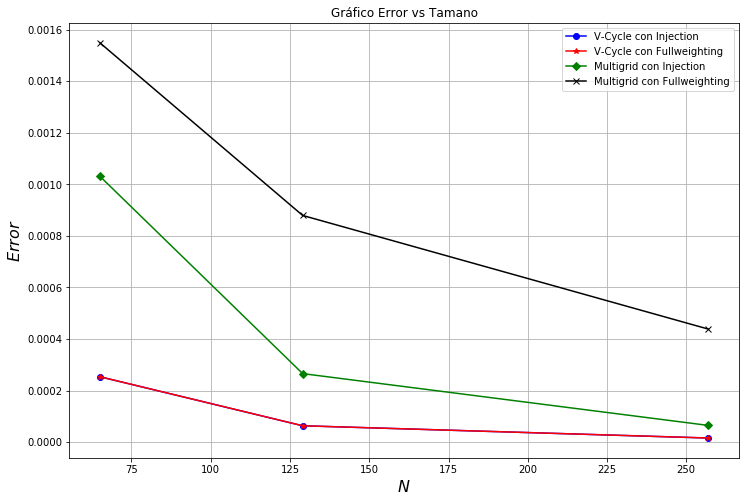

In [36]:
plotINFW(N, error_vc_in, error_vc_fw, error_mg_in, error_mg_fw)

Del gráfico se puede concluir que no existen diferencias significativas en los resultados al utilizar *Injection* o *FullWeighting* como restricción en el algoritmo *V-Cycle*, a diferencia de *Multigrid* que tiene mejores resultados al utilizar *Injection*.

<div id="conclusiones" />
## 3. Conclusiones

Del desarrollo del proyecto se obtuvieron las siguientes conclusiones:

* Los algoritmos *Multigrid* son computacionalmente menos costosos que los de relajación como el *Gauss-Seidel*.
* Con los métodos *Multigrid* es posible obtener errores comparables con una menor cantidad de cómputo.
* No se aprecian mejoras significativas en los resultados al utilizar *Injection* en vez de *Full-Weighting* en *V-Cycle*, no así para *Multigrid* donde *Injection* muestra mejores resultados.
* Se puede inferir que con el uso de interpolación lineal se pierde precisión en la solución, pensando en otros tipos de interpolacion como la cúbica, spline, entre otras.
* Por otra parte, se puede culpar el uso de *Numba* en que el resultado exacto de número de operaciones en función de la relajación no coincida.

<div id="referencias" />
## 4. Referencias

* [1] Brandt, A., & Livne, O. E. (2011). Multigrid Techniques: 1984 Guide with Applications to Fluid Dynamics, Revised Edition. Society for Industrial and Applied Mathematics.
* [2] Briggs, W. L., Henson, V. E., & McCormick, S. F. (2000). A multigrid tutorial. Society for Industrial and Applied Mathematics.
* [3] Stewart, J. M. (2014). Python for scientists. Cambridge University Press. 	
* [4] Barba, L (2014). Practical Numerical Methods with Python. 
